# Лабораторная работа: Спайковые нейронные сети

# Теоретическая часть

## 1. Суть нейроморфных вычислений и спайковых нейронных сетей

Нейроморфные вычисления — это парадигма, направленная на создание вычислительных систем, архитектура и принципы работы которых вдохновлены биологическим мозгом. В отличие от классических нейронных сетей, которые оперируют непрерывными значениями активаций (например, вещественными числами), спайковые нейронные сети (Spiking Neural Networks, SNN) используют **дискретные события во времени** — спайки (или потенциалы действия).

Основная цель нейроморфных систем — достичь высокой **энергоэффективности** и способности эффективно обрабатывать **временно́зависимые данные** (аудио, видео, сенсорные потоки), что критически важно для задач встраиваемого ИИ, робототехники и интерфейсов мозг-компьютер.


## 2. Модель нейрона LIF (Leaky Integrate-and-Fire)

Модель LIF является одной из самых распространенных и вычислительно эффективных моделей спайкового нейрона. Она описывает динамику мембранного потенциала $V(t)$.

Уравнение мембранного потенциала:

$$
\tau_m \frac{dV(t)}{dt} = -(V(t) - V_{rest}) + R_m I(t)
$$

где:
- $V(t)$ — мембранный потенциал в момент времени $t$,
- $\tau_m = R_m C_m$ — постоянная времени мембраны (произведение сопротивления $R_m$ и емкости $C_m$),
- $V_{rest}$ — потенциал покоя,
- $R_m$ — мембранное сопротивление,
- $I(t)$ — суммарный входной ток (от синапсов).

При достижении порогового потенциала $V_{th}$ нейрон генерирует спайк, и его потенциал сбрасывается до потенциала покоя $V_{rest}$ на период рефрактерности $\tau_{ref}$:

$$
\text{if } V(t) \geq V_{th} \text{, then:} \\
V(t) \rightarrow V_{rest} \\
\text{Запрет на срабатывание на время } \tau_{ref}
$$

## 3. Спайк-тайм-зависимая пластичность (STDP)

STDP — это биоинспирированное правило обучения, которое модифицирует силу синаптической связи (вес $w$) на основе временной корреляции между спайками пресинаптического и постсинаптического нейронов.

Формально, изменение веса $\Delta w$ определяется так:

$$
\Delta w =
\begin{cases}
A_{+} \cdot \exp\left(-\frac{\Delta t}{\tau_{+}}\right), & \text{если } \Delta t > 0 \text{ (пре-спайк до пост-спайка)} \\
-A_{-} \cdot \exp\left(-\frac{|\Delta t|}{\tau_{-}}\right), & \text{если } \Delta t < 0 \text{ (пре-спайк после пост-спайка)}
\end{cases}
$$

где:
- $\Delta t = t_{post} - t_{pre}$ — разница во времени между постсинаптическим и пресинаптическим спайками,
- $A_{+}, A_{-}$ — амплитуды усиления и ослабления связи,
- $\tau_{+}, \tau_{-}$ — временные константы для потенциации и депрессии.

STDP реализует принцип Хебба: *"Neurons that fire together, wire together"* (Нейроны, которые возбуждаются вместе, связываются вместе).

## Практическая часть

В данной работе вам предлагается реализовать и исследовать простую спайковую нейронную сеть на основе модели LIF с обучением по правилу STDP. Вы должны:

1.  Реализовать модель LIF-нейрона и исследовать его отклик на различные входные токи.
2.  Создать сеть из нескольких LIF-нейронов (например, входной слой, скрытый слой) и визуализировать распространение спайковой активности.
3.  Реализовать правило обучения STDP для синаптических связей.
4.  Обучить сеть на простой задаче (например, ассоциации паттернов) или классификации простых спайковых последовательностей.
5.  Проанализировать динамику весов, итоговую активность сети и эффективность обучения.

In [86]:


import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from dataclasses import dataclass
from typing import List
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader

Класс с реализацией Lif-нейрона

In [87]:
@dataclass
class LIFNeuron:
    tau_m: float = 20.0
    v_rest: float = -70.0
    v_thresh: float = -55.0
    v_reset: float = -75.0
    r_m: float = 10.0
    tau_ref: float = 4.0

    def __post_init__(self):
        self.v = self.v_rest
        self.refractory_until = 0
        self.spike_times = []

    def step(self, I_inj: float, dt: float, t: float) -> bool:
        if t < self.refractory_until:
            self.v = self.v_reset
            return False

        dv = (-(self.v - self.v_rest) + self.r_m * I_inj) / self.tau_m
        self.v += dv * dt

        if self.v >= self.v_thresh:
            self.v = self.v_reset
            self.refractory_until = t + self.tau_ref
            self.spike_times.append(t)
            return True
        return False

Класс сети из LIF нейронов

In [ ]:
class SimpleSNN:
    def __init__(self, n_inputs=28*28, n_outputs=10):
        self.n_outputs = n_outputs
        self.weights = np.random.randn(n_outputs, n_inputs) * 0.05
        self.neurons = [LIFNeuron() for _ in range(n_outputs)]

    def forward(self, x, dt=1.0, T=50):
        spikes = np.zeros(self.n_outputs)
        t_range = np.arange(0, T, dt)

        for neuron in self.neurons:
            neuron.v = neuron.v_rest
            neuron.refractory_until = 0

        for t in t_range:
            current = 20 * (self.weights @ x)
            for i, neuron in enumerate(self.neurons):
                if neuron.step(current[i], dt, t):
                    spikes[i] += 1

        return spikes

    def predict(self, x):
        spikes = self.forward(x)
        return np.argmax(spikes)

Классическая нейронная сеть

In [89]:
class ANN(nn.Module):
    def __init__(self, n_inputs=20, n_outputs=2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_inputs, 32),
            nn.ReLU(),
            nn.Linear(32, n_outputs)
        )

    def forward(self, x):
        return self.net(x)

Изменена функция plot_neuron_activity для отображения зависимости точности от уровня шума.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_accuracy_vs_noise(noise_levels, snn_accs, ann_accs):
    snn_percent = np.array(snn_accs) * 100
    ann_percent = np.array(ann_accs) * 100
    plt.figure(figsize=(9, 5))
    plt.plot(noise_levels, snn_percent, 'o-', linewidth=2, label='LIF-SNN')
    plt.plot(noise_levels, ann_percent, 's-', linewidth=2, label='Классическая ANN')
    for x, y in zip(noise_levels, snn_percent):
        plt.text(x, y + 1, f"{y:.1f}%", ha='center', fontsize=9)
    plt.xlabel('Уровень случайных спайков (noise rate)')
    plt.ylabel('Точность (%)')
    plt.title('Влияние шума на точность LIF-SNN и классической сети')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Функции для обучения и тестирования сетей. При генерации датасета с синтетическими spike-паттернами важно указать корректное значение разницы частот (high_rate и low_rate) - это влияет на сложность задачи, решаемой нейронной сетью. Также присутствует задача бинарной классификации (pattern_type = 0 или 1)

In [ ]:
def poisson_noise(x, rate=0.1):
    noise = torch.rand_like(x) < rate
    return x + noise.float()

transform = transforms.Compose([
    transforms.ToTensor()
])

import numpy as np

def generate_spike_pattern(n_neurons=20, duration=100, dt=1.0, high_rate=16, low_rate=6, pattern_type=0):
    time_steps = int(duration / dt)
    spikes = np.zeros((time_steps, n_neurons))

    for n in range(n_neurons):

        if pattern_type == 0:
            rate = high_rate if n < n_neurons//2 else low_rate
        else:
            rate = low_rate if n < n_neurons//2 else high_rate

        p_spike = rate * dt / 1000.0
        spikes[:, n] = np.random.rand(time_steps) < p_spike

    return spikes


def generate_dataset(n_samples=200):
    data = []
    labels = []

    for _ in range(n_samples//2):
        data.append(generate_spike_pattern(pattern_type=0))
        labels.append(0)

        data.append(generate_spike_pattern(pattern_type=1))
        labels.append(1)

    return data, np.array(labels)

class SyntheticSpikeDataset(Dataset):
    def __init__(self, n_samples=200):
        data, labels = generate_dataset(n_samples)
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        spike_matrix = self.data[idx]
        spike_counts = spike_matrix.sum(axis=0)
        return torch.tensor(spike_counts, dtype=torch.float32), \
               torch.tensor(self.labels[idx], dtype=torch.long)


def train_ann(noise_level=0.0, epochs=5):
    dataset = SyntheticSpikeDataset(500)
    loader = DataLoader(dataset, batch_size=32, shuffle=True)

    model = ANN()
    opt = optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        correct = 0
        total = 0

        for x, y in loader:
            if noise_level > 0:
                x = poisson_noise(x, noise_level)

            logits = model(x)
            loss = loss_fn(logits, y)

            opt.zero_grad()
            loss.backward()
            opt.step()

            pred = logits.argmax(1)
            correct += (pred == y).sum().item()
            total += len(y)

        print(f"ANN Epoch {epoch+1}, acc: {correct/total:.3f}")

    return model

def softmax(x):
    e = np.exp(x - np.max(x))
    return e / np.sum(e)

def train_snn(snn, dataset, epochs=5, lr=0.01):
    for epoch in range(epochs):
        correct = 0
        total = 0

        for spike_matrix, label in zip(dataset.data, dataset.labels):
            x = spike_matrix.sum(axis=0)

            spikes = snn.forward(x)
            probs = softmax(spikes)

            pred = np.argmax(probs)
            if pred == label:
                correct += 1
            total += 1

            target = np.zeros(snn.n_outputs)
            target[label] = 1

            error = probs - target

            for i in range(snn.n_outputs):
                snn.weights[i] -= lr * error[i] * x

        print(f"SNN Epoch {epoch+1}, acc: {correct/total:.3f}")

    return snn


def test_ann(model, noise_level=0.0):
    dataset = SyntheticSpikeDataset(200)
    loader = DataLoader(dataset, batch_size=64)

    correct = 0
    total = 0

    with torch.no_grad():
        for x, y in loader:
            if noise_level > 0:
                x = poisson_noise(x, noise_level)

            pred = model(x).argmax(1)
            correct += (pred == y).sum().item()
            total += len(y)

    return correct / total


def test_snn(snn, noise_level=0.0):
    dataset = SyntheticSpikeDataset(200)

    correct = 0

    for spike_matrix, label in zip(dataset.data, dataset.labels):
        x = spike_matrix.sum(axis=0)

        if noise_level > 0:
            x += (np.random.rand(len(x)) < noise_level)

        pred = snn.predict(x)

        if pred == label:
            correct += 1

    return correct / len(dataset)

В функции main добавлены несколько запусков с разными уровнями шума и симуляции SNN и классической сети (процесс принятия решения и подсчёт правильных классификаций сразу для двух моделей)

In [92]:
def add_spike_noise(I_inj, noise_rate, dt):
    noise = np.random.rand(len(I_inj)) < noise_rate * dt
    noise = noise.astype(float)
    return I_inj + noise

ANN Epoch 1, acc: 0.692
ANN Epoch 2, acc: 0.942
ANN Epoch 3, acc: 0.980
ANN Epoch 4, acc: 0.990
ANN Epoch 5, acc: 0.992
SNN Epoch 1, acc: 0.928
SNN Epoch 2, acc: 0.972
SNN Epoch 3, acc: 0.972
SNN Epoch 4, acc: 0.976
SNN Epoch 5, acc: 0.978
Noise | ANN acc | SNN acc
0.00 | 0.975 | 0.985
0.10 | 0.980 | 0.990
0.20 | 0.965 | 0.990
0.30 | 0.965 | 1.000
0.40 | 0.960 | 0.955
0.50 | 0.975 | 0.970
0.60 | 0.960 | 0.955
0.70 | 0.975 | 0.975
0.80 | 0.965 | 0.980
0.90 | 0.980 | 0.980


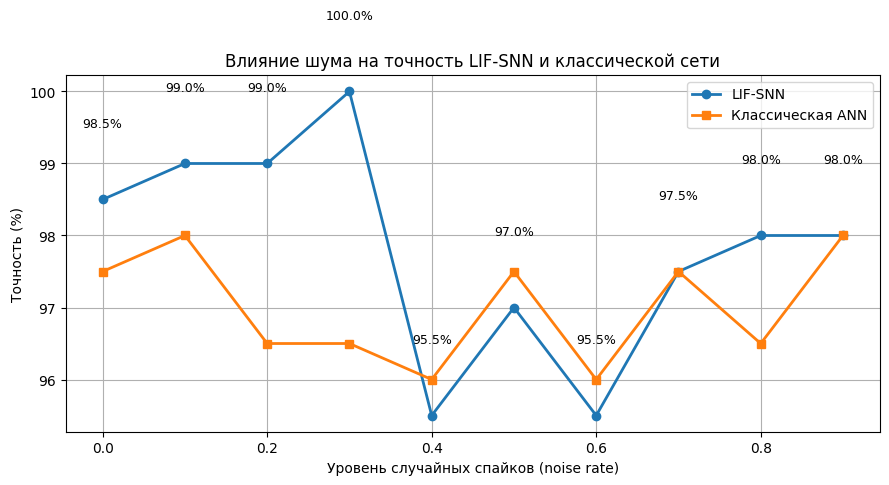

In [ ]:

if __name__ == "__main__":

    noise_levels = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

    dataset = SyntheticSpikeDataset(500)

    ann = train_ann()
    snn = train_snn(SimpleSNN(n_inputs=20, n_outputs=2), dataset)

    ann_accs = []
    snn_accs = []

    print("Шум | Точность ANN | Точность SNN")

    for n in noise_levels:
        ann_acc = test_ann(ann, n)
        snn_acc = test_snn(snn, n)

        ann_accs.append(ann_acc)
        snn_accs.append(snn_acc)

        print(f"{n:.2f} | {ann_acc:.3f} | {snn_acc:.3f}")

    plot_accuracy_vs_noise(noise_levels, snn_accs, ann_accs)


Можно увидеть, что при низких уровнях шума (до 0.3) SNN имеет точность выше, чем классическая сеть, при этом начиная с уровня шума 0.4 разница между сетями становится незначительной